# Email Spam Detection: Tfidf, Deep Learning & Transformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,f1_score
from sklearn.metrics import roc_auc_score, auc
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import string

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Create a list of stopwords
stop_words = list(set(stopwords.words('english')))

# Create a list of punctuation
punc = list(string.punctuation)

**Load dataset**

In [5]:
def load_dataset(dataset_path):
    df = pd.read_csv(dataset_path,usecols=['v1','v2'],encoding='ISO-8859-1')
    print("Number of records:",len(df))
    print("\nColumn Types:\n",df.dtypes)
    return df

In [6]:
df = load_dataset(r'/kaggle/input/email-spam-detection-dataset-classification/spam.csv')
df.head()

Number of records: 5572

Column Types:
 v1    object
v2    object
dtype: object


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Rename columns

df.rename(columns={'v1':'label','v2':'text'},inplace=True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# label count
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

**Text Preprocessing**

In [8]:
def preprocess_text(text):
    # convert to lowercase
    text = str(text).lower()
    # remove special characters
    text = re.sub(r'[^\w ]+','',text)
    # remove non-ascii
    text = ''.join(word for word in text if ord(word) < 128)
    # remove punctuations
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove digits
    text = re.sub(r'[\d]+','',text)
    # remove single letters
    text = ' '.join(word for word in text.split() if len(word)>1)
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # remove extra spaces
    text = ' '.join(text.split())
    return text

In [9]:
# Apply preprocessing

df_final = df.copy()
df_final['text'] = df_final.loc[:,'text'].apply(lambda x:preprocess_text(x))

# Change label to numeric
df_final['label'] = df_final.loc[:,'label'].map({'ham':0,'spam':1})
df_final.head()

,label,text
0,0,go jurong point crazy available bugis great wo...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,dun say early hor already say
4,0,nah dont think goes usf lives around though


**Data Visualization**

In [10]:
def visualize(label):
    words = ''
    for txt in df_final[df_final['label'] == label]['text']:
        words = words + txt + ' '
        
    wordcloud = WordCloud(width=500,height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

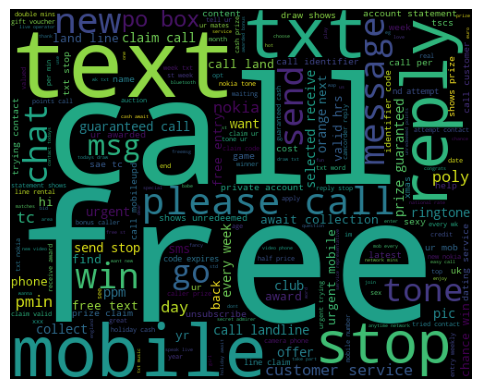

In [11]:
# Visualize Spam text

visualize(1)

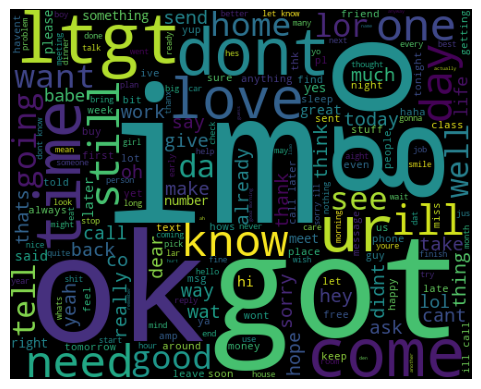

In [12]:
# Visualize Ham

visualize(0)

**Train-Test Split**

In [13]:
# Split the dataset into train and test

X = df_final['text']
y = df_final['label']

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4457,), (1115,), (4457,), (1115,))

# Method 1: TF-IDF with Classifiers

**TF-IDF**

In [14]:
tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print("Vocabulary size:",len(tfidf.vocabulary_))

Vocabulary size: 7415


**Pipeline and Function for classifier training and evaluation**

In [15]:
def classifer_train(classifier,initials):
    pipe = Pipeline([('tfidf',TfidfVectorizer()),(initials,classifier)])
    model = pipe.fit(X_train,y_train)
    print("Train score:",model.score(X_train,y_train))
    # Predict on test set
    y_predict = model.predict(X_test)
    X_train_vec = pipe['tfidf'].fit_transform(X_train)
    X_test_vec = pipe['tfidf'].transform(X_test)
    prob_test = model.predict_proba(X_test)[:,1]
    
    print('Accuracy Score:',accuracy_score(y_test,y_predict))
    print('\n\t\tClassification Report:\n\n',classification_report(y_test,y_predict))
    print('\nAUC score for test:',roc_auc_score(y_test,prob_test))
    print('\nConfusion Matrix')
    plot_confusion_matrix(confusion_matrix(y_test,y_predict))
    plt.show()
    return model

**Random Forest Classifier**

Train score: 1.0
Accuracy Score: 0.9748878923766816

		Classification Report:

               precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115


AUC score for test: 0.9825336612614115

Confusion Matrix


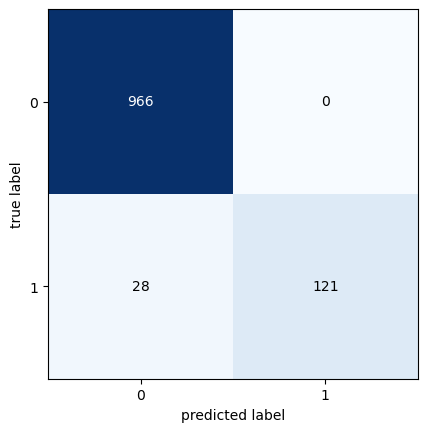

In [16]:
model_rfc = classifer_train(RandomForestClassifier(n_estimators=200),'rfc')

**Multinomial NB**

Train score: 0.9780121157729414
Accuracy Score: 0.9632286995515695

		Classification Report:

               precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115


AUC score for test: 0.9786047771895453

Confusion Matrix


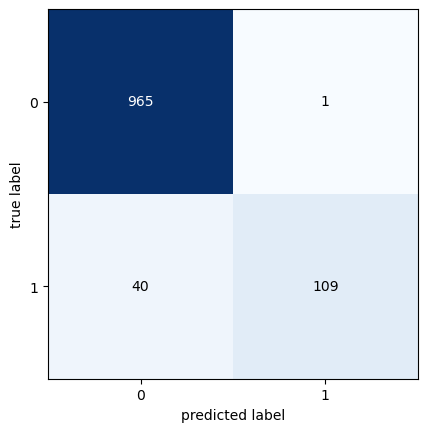

In [17]:
model_nb = classifer_train(MultinomialNB(),'mnb')

**Logistic Regression**

Train score: 0.9665694413282477
Accuracy Score: 0.9623318385650225

		Classification Report:

               precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.72      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115


AUC score for test: 0.9847673239123488

Confusion Matrix


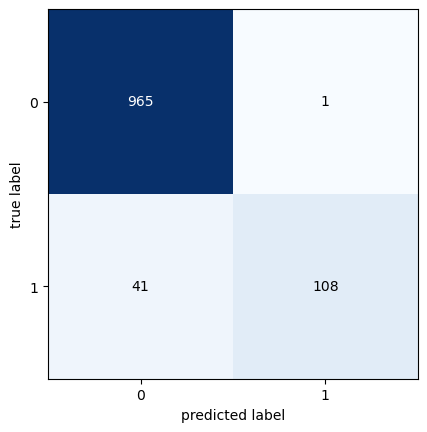

In [18]:
model_lr = classifer_train(LogisticRegression(solver='lbfgs'),'lr')

**XGBoost**

Train score: 0.9887816917208885
Accuracy Score: 0.968609865470852

		Classification Report:

               precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.97      0.79      0.87       149

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115


AUC score for test: 0.959641224450095

Confusion Matrix


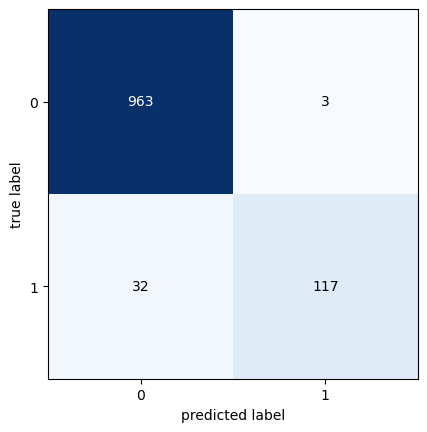

In [19]:
model_xgb = classifer_train(xgb.XGBClassifier(),'xgb')

# Method 2: Deep Learning

In [39]:
import tensorflow
from keras.layers import Embedding,Dense,Activation
from keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D,Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

**Tokenize data**

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# train sequences
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_counts) + 1
vocab_size

7416

**Padding**

In [25]:
# Max length for train
max_length = max([len(seq) for seq in train_seq])
max_length

80

In [26]:
X_train_final = pad_sequences(train_seq,maxlen=max_length,padding='post')
X_test_final = pad_sequences(test_seq,maxlen=max_length,padding='post')

X_train_final.shape,X_test_final.shape

((4457, 80), (1115, 80))

In [41]:
# Convert labels to keras categorical

y_train_final = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_final = np.asarray(y_test).astype('float32').reshape((-1,1))

y_train_final.shape,y_test_final.shape

((4457, 1), (1115, 1))

**Model Building: CNN**

In [58]:
vector_size = 100
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=vector_size,input_length=max_length))
model.add(Conv1D(32,2,activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 80, 100)           741600    
                                                                 
 conv1d_12 (Conv1D)          (None, 79, 32)            6432      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 39, 32)           0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 39, 32)            0         
                                                                 
 dense_23 (Dense)            (None, 39, 32)            1056      
                                                                 
 global_max_pooling1d_10 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                   

**Model Training: CNN**

In [60]:
# Compile

model.compile(optimizer= Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train_final,y_train_final,epochs=4,validation_data=(X_test_final,y_test_final))
history

Epoch 1/4
140/140 [==============================] - 2s 7ms/step - loss: 0.0080 - accuracy: 0.9989 - val_loss: 0.0941 - val_accuracy: 0.9749
Epoch 2/4
140/140 [==============================] - 1s 6ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.1107 - val_accuracy: 0.9785
Epoch 3/4
140/140 [==============================] - 1s 6ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1064 - val_accuracy: 0.9776
Epoch 4/4
140/140 [==============================] - 1s 6ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0977 - val_accuracy: 0.9776


We get an accuracy of 0.97 with CNN

**Model Building : LSTM**

In [61]:
vector_size = 100
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=vector_size,input_length=max_length))
model.add(Bidirectional(LSTM(32)))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 80, 100)           741600    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 775,969
Trainable params: 775,841
Non-trainable params: 128
_________________________________________________________________
None


**Model Training: LSTM**

In [62]:
# Compile

model.compile(optimizer= Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train_final,y_train_final,epochs=4,validation_data=(X_test_final,y_test_final))
history

Epoch 1/4
140/140 [==============================] - 7s 19ms/step - loss: 0.2555 - accuracy: 0.9094 - val_loss: 0.1896 - val_accuracy: 0.9686
Epoch 2/4
140/140 [==============================] - 2s 13ms/step - loss: 0.0638 - accuracy: 0.9827 - val_loss: 0.1139 - val_accuracy: 0.9605
Epoch 3/4
140/140 [==============================] - 2s 14ms/step - loss: 0.0275 - accuracy: 0.9937 - val_loss: 0.0786 - val_accuracy: 0.9785
Epoch 4/4
140/140 [==============================] - 2s 13ms/step - loss: 0.0125 - accuracy: 0.9982 - val_loss: 0.0619 - val_accuracy: 0.9857


We get an accuracy of 0.98 with LSTM

# Method 3: Transformers

In [9]:
from transformers import pipeline
from datasets import load_dataset

**Convert dataset into format for transformers**

In [24]:
# Save to file

df_copy = df.copy()
df_copy['label'] = df_copy.loc[:,'label'].map({"ham":0,"spam":1})

df_copy.to_csv('df.csv',index=None)

# Convert format
raw_dataset = load_dataset('csv',data_files='df.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-31f6ded38824f645/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 5572
    })
})

**Split into train and test**

In [25]:
split = raw_dataset['train'].train_test_split(train_size=0.7,seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 3900
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1672
    })
})

**Define tokenizer**

In [13]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
# Function for tokenizing

def tokenize_fn(batch):
    return tokenizer(str(batch['text']),truncation=True)

**Tokenize dataset**

In [26]:
tokenized_dataset = split.map(tokenize_fn)
tokenized_dataset

  0%|          | 0/3900 [00:00<?, ?ex/s]

  0%|          | 0/1672 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 3900
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1672
    })
})

**Dynamic Padding**

In [27]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

**Evaluate**

In [17]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.6 MB/s eta 0:00:00


In [19]:
# Function for evaluation

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = np.mean(predictions==labels)
    f1 = f1_score(labels,predictions,average='macro')
    return({'accuracy':acc,'f1':f1})

**Training**

In [20]:
id2label = {0: "Ham", 1: "Spam"}
label2id = {"Ham": 0, "Spam": 1}

In [21]:
# Model

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.

In [28]:
training_args = TrainingArguments(output_dir='email_spam_detection',
                                  learning_rate=2e-5,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=2,
                                  per_device_train_batch_size=10,
                                  per_device_eval_batch_size=8)

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['test'],
                  tokenizer = tokenizer,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.029446,0.991627,0.983205
2,No log,0.026532,0.992823,0.985455


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=390, training_loss=0.06596530033991888, metrics={'train_runtime': 69.913, 'train_samples_per_second': 111.567, 'train_steps_per_second': 5.578, 'total_flos': 134511329221200.0, 'train_loss': 0.06596530033991888, 'epoch': 2.0})

**Predictions on test set**

In [29]:
savedmodel = pipeline('text-classification',
                      model='/kaggle/working/email_spam_detection/checkpoint-390',
                      device=0)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [30]:
split['test']

Dataset({
    features: ['label', 'text'],
    num_rows: 1672
})

In [31]:
test_prediction = savedmodel(split['test']['text'])
test_prediction[:5]

[{'label': 'Ham', 'score': 0.9980362057685852},
 {'label': 'Ham', 'score': 0.9979808926582336},
 {'label': 'Ham', 'score': 0.9980379939079285},
 {'label': 'Ham', 'score': 0.9971246123313904},
 {'label': 'Ham', 'score': 0.996425449848175}]

In [32]:
# Get labels

pred_labels = [label2id[d['label']] for d in test_prediction]
pred_labels[:5]

[0, 0, 0, 0, 0]

In [33]:
print('Accuracy:',accuracy_score(split['test']['label'],pred_labels))

Accuracy: 0.992822966507177


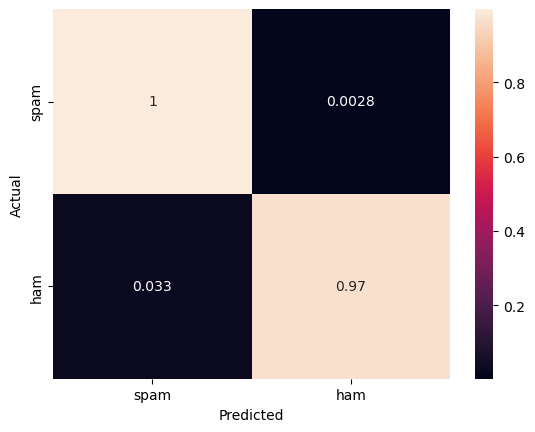

In [34]:
# Confusion matrix
cm = confusion_matrix(split['test']['label'],pred_labels,normalize='true')

def plot_cm(cm):
    classes = ['spam','ham']
    df_cm = pd.DataFrame(cm,index=classes,columns=classes)
    ax = sns.heatmap(df_cm,annot=True,fmt='.2g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plot_cm(cm)